# Assessing the Effectiveness of VPD Bike Theft Prevention Programs

##### STAT 201 Group 32: Angela Felicia, Christin Wang, Linda Chu, Yifan Hao

## Introduction

Bike theft is a major issue in Vancouver. According to the Vancouver Police Department (VPD), over 2,000 bikes are stolen in Vancouver every year (Vancouver Police Department, n.d.). To combat this issue, the VPD parterned with Project 529 to implement a theft recovery and deterrent system for bikes, which was reported to be effective (McIntyre, 2023; Nettle, Nott, & Bateson, 2012).

### Our Question               
We want to assess these claims of effectiveness through statistical inference. We will compare the proportion of bike theft in Vancouver in *2012* (a year before Project 529 was created) to the proportion of bike theft in *2022* (the most recently concluded year) and identify a confidence interval for this difference-in-proportions.

We plan to focus on the Central Business District (Downtown). As bike theft often occurs around transport hubs or worksites, and high crime rate areas like Downtown (Malleson, Steenbeek, & Andresen, 2019), a valid reduction in bike theft would be more evident here.

### Dataset
Our chosen dataset is the VPD Crime dataset which contains information about the date, type, and location of a crime in Vancouver from 2003 to 2023.

## Methods and Results

### I. Preliminary Operations

#### 1. Loading the datasets


In [41]:
library(dplyr)
library(ggplot2)
library(infer)
library(readr)
library(tidyr)
install.packages("cowplot")
library(cowplot)
install.packages("broom")
library(broom)


The downloaded binary packages are in
	/var/folders/h_/bf_d_hfx31ggd_wrmv3r_jp80000gn/T//Rtmp53pIFQ/downloaded_packages

The downloaded binary packages are in
	/var/folders/h_/bf_d_hfx31ggd_wrmv3r_jp80000gn/T//Rtmp53pIFQ/downloaded_packages


In [42]:
cbd_2012 <- read_csv("https://drive.google.com/u/0/uc?id=1hYkqOrxvwQ7rXIw8jGVoDlUwL0a5Vn9b&export=download")
cbd_2022 <- read_csv("https://drive.google.com/u/0/uc?id=1rDToNyTlyzyVwrLMV4tamVZOdwQBVXRe&export=download")

head(cbd_2012)
head(cbd_2022)

Rows: 8821 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10614 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE                       YEAR MONTH DAY HOUR MINUTE HUNDRED_BLOCK   
1 Break and Enter Commercial 2012 11    26   9   38     10XX BEACH AVE  
2 Break and Enter Commercial 2012 10    11  13    0     10XX CAMBIE ST  
3 Break and Enter Commercial 2012  1     8  22    1     10XX CANADA PL  
4 Break and Enter Commercial 2012 10    27  21   35     10XX CANADA PL  
5 Break and Enter Commercial 2012 12    13   5    0     10XX HAMILTON ST
6 Break and Enter Commercial 2012 12    15  22    0     10XX HAMILTON ST
  NEIGHBOURHOOD             X        Y      
1 Central Business District 490268.4 5458143
2 Central Business District 491327.6 5458026
3 Central Business District 491519.5 5459521
4 Central Business District 491586.3 5459502
5 Central Business District 491211.0 5458148
6 Central Business District 491261.0 5458199

TYPE                       YEAR MONTH DAY HOUR MINUTE HUNDRED_BLOCK   
1 Break and Enter Commercial 2022  2    13   6   22     10XX CANADA PL  
2 Break and Enter Commercial 2022  7    16   9   10     10XX CANADA PL  
3 Break and Enter Commercial 2022 10     2   6   29     10XX CANADA PL  
4 Break and Enter Commercial 2022  1     7   6    2     10XX CANADA PL  
5 Break and Enter Commercial 2022  2    26  18   16     10XX DUNSMUIR ST
6 Break and Enter Commercial 2022  1    21   3   30     10XX DUNSMUIR ST
  NEIGHBOURHOOD             X        Y      
1 Central Business District 491493.3 5459542
2 Central Business District 491493.3 5459542
3 Central Business District 491493.3 5459542
4 Central Business District 491493.4 5459542
5 Central Business District 491237.8 5459259
6 Central Business District 491238.7 5459259

#### 2. Tidying the data
Here we select our variable of interest (TYPE) to remove unecessary columns and shorten long labels.

In [43]:
cbd_2012 <- cbd_2012 %>%
  select(TYPE) %>%
  mutate(TYPE = recode(TYPE, 
                       "Break and Enter Commercial" = "B&E Commercial",
                       "Break and Enter Residential/Other" = "B&E Residential/Other",
                       "Vehicle Collision or Pedestrian Struck (with Fatality)" = "MVA (with Fatality)",
                       "Vehicle Collision or Pedestrian Struck (with Injury)" = "MVA (with Injury)"))

cbd_2022 <- cbd_2022 %>%
  select(TYPE) %>%
  mutate(TYPE = recode(TYPE, 
                       "Break and Enter Commercial" = "B&E Commercial",
                       "Break and Enter Residential/Other" = "B&E Residential/Other",
                       "Vehicle Collision or Pedestrian Struck (with Fatality)" = "MVA (with Fatality)",
                       "Vehicle Collision or Pedestrian Struck (with Injury)" = "MVA (with Injury)"))

head(cbd_2012)
head(cbd_2022)

TYPE          
1 B&E Commercial
2 B&E Commercial
3 B&E Commercial
4 B&E Commercial
5 B&E Commercial
6 B&E Commercial

TYPE          
1 B&E Commercial
2 B&E Commercial
3 B&E Commercial
4 B&E Commercial
5 B&E Commercial
6 B&E Commercial

#### 3. Plotting relevant raw data
We plotted the count for each crime in 2012 and 2022 in bar graphs. From the plots, we can see that the bar for bike theft is relatively short, meaning we can expect the proportions and any difference in the proportions to be generally low. Moreover, the bar for bike theft is shorter in 2022 than for 2012 which indicates a possibility of reduction in bike theft between 2012 and 2022.

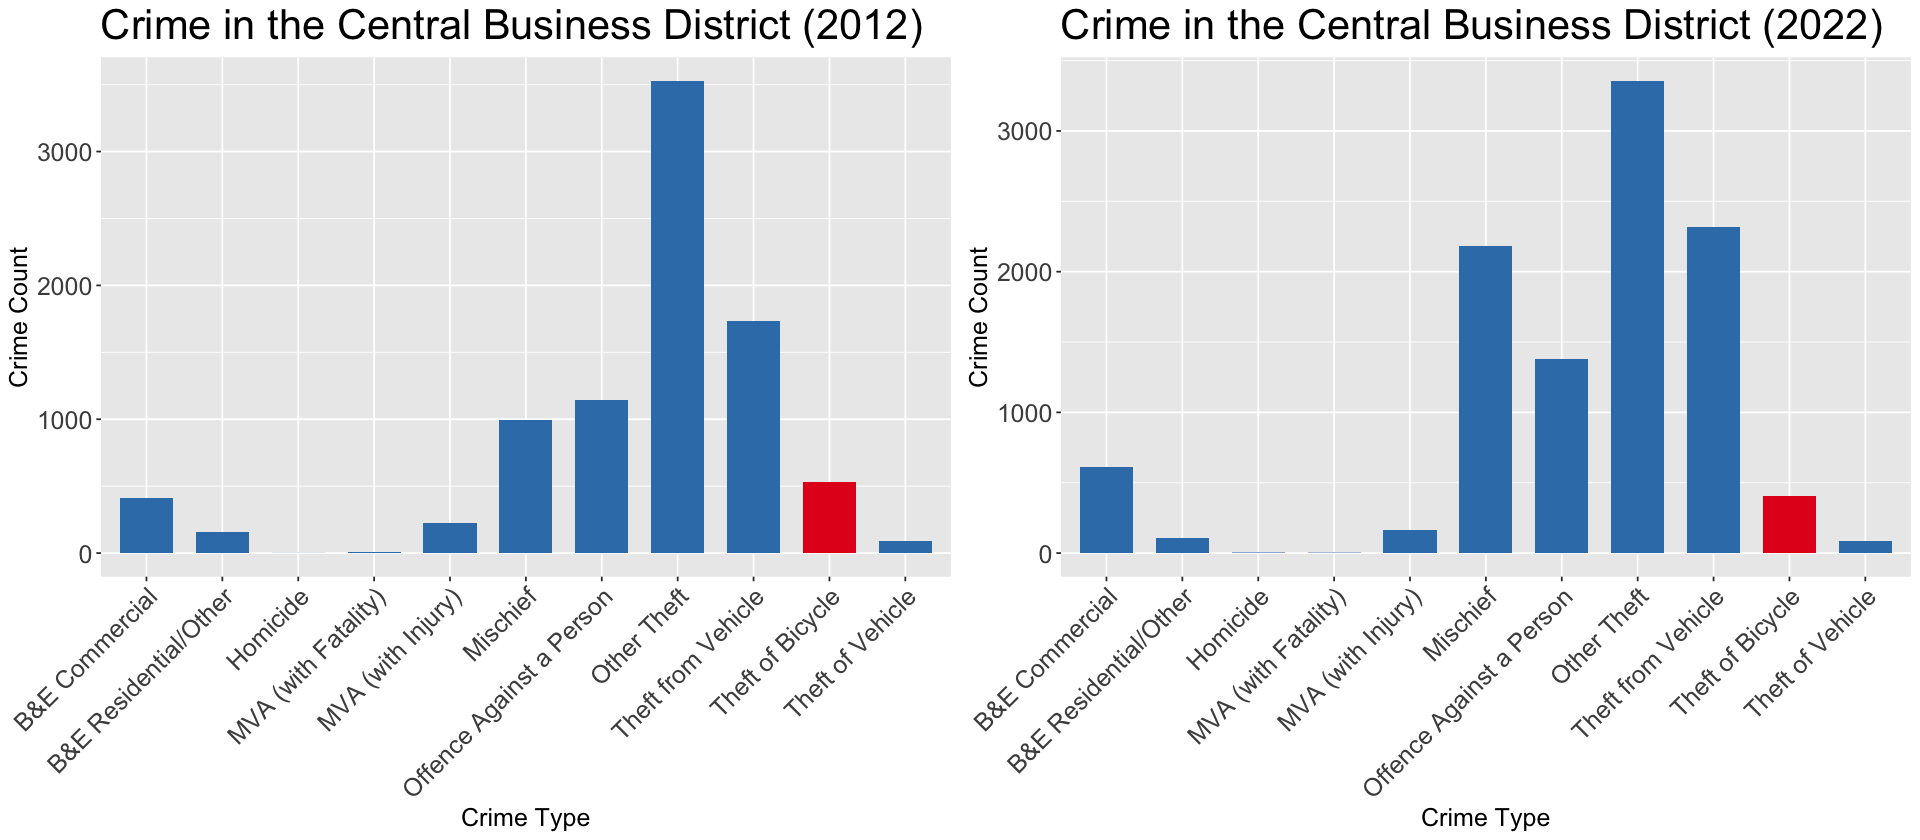

In [44]:
options(repr.plot.width = 16, repr.plot.height = 7)

cbd_2012_dist <- cbd_2012 %>%
  ggplot(aes(x = TYPE,
             fill = factor(ifelse(TYPE=="Theft of Bicycle","Category of Interest","Other")))) +
  geom_bar(width = 0.7, show.legend = FALSE) +
  scale_fill_brewer(palette = "Set1") +
  labs(x = "Crime Type", y = "Crime Count", title = "Crime in the Central Business District (2012)") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 15),
        axis.text.y = element_text(size = 15),
        axis.title = element_text(size = 15),
        legend.text = element_text(size = 15),
        plot.title = element_text(size = 25))

cbd_2022_dist <- cbd_2022 %>%
  ggplot(aes(x = TYPE,
             fill = factor(ifelse(TYPE=="Theft of Bicycle","Category of Interest","Other")))) +
  geom_bar(width = 0.7, show.legend = FALSE) +
  scale_fill_brewer(palette = "Set1") +
  labs(x = "Crime Type", y = "Crime Count", title = "Crime in the Central Business District (2022)") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 15),
        axis.text.y = element_text(size = 15),
        axis.title = element_text(size = 15),
        legend.text = element_text(size = 15),
        plot.title = element_text(size = 25))

plot_grid(cbd_2012_dist, cbd_2022_dist)

#### 4. Estimating the proportion of bike thefts

In [45]:
bike_theft_2012 <- cbd_2012 %>%
  summarize(bike_theft = sum(TYPE == "Theft of Bicycle"),
            prop_bike_theft_2012 = bike_theft / n()) %>%
  select(prop_bike_theft_2012)

bike_theft_2022 <- cbd_2022 %>%
  summarize(bike_theft = sum(TYPE == "Theft of Bicycle"),
            prop_bike_theft_2022 = bike_theft / n()) %>%
  select(prop_bike_theft_2022)

diff_in_props_22_12 <- tibble(diff_in_props = pull(bike_theft_2022) - pull(bike_theft_2012))

bike_theft_summary <- tibble(bike_theft_2012, bike_theft_2022, diff_in_props_22_12)
bike_theft_summary


prop_bike_theft_2012 prop_bike_theft_2022 diff_in_props
1 0.06019726           0.03806294           -0.02213432

### II. Hypothesis Test

### Method 1: Simulation-based


replicate stat         
1 1         -0.0001307328
2 2         -0.0078112305
3 3          0.0006995913
4 4         -0.0001307328
5 5          0.0009071723
6 6         -0.0030368671

Warning message in min(diff(unique_loc)):
"no non-missing arguments to min; returning Inf"
Warning message:
"Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information."


p_value
1 0

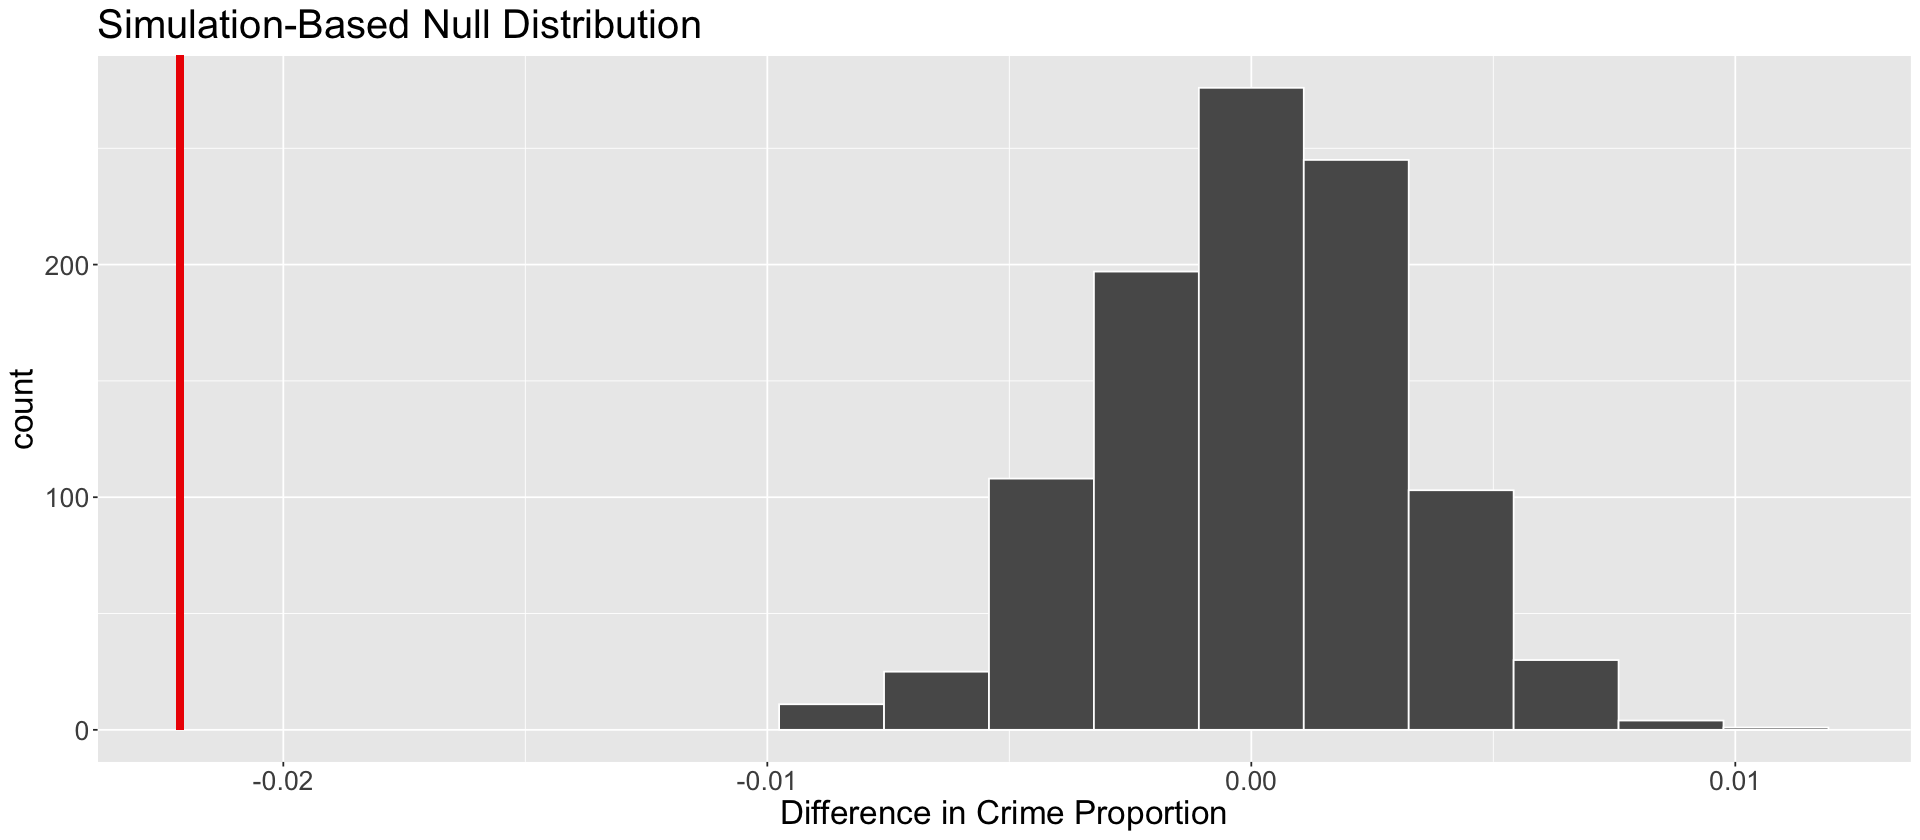

In [48]:
# Combine both data sets into a single data set
bike_theft_2012_2022 <- rbind(mutate(cbd_2012, year = "2012"), mutate(cbd_2022, year = "2022")) |>
    mutate(bike_theft = (TYPE == "Theft of Bicycle"))

# Generate the null distribution
null_dist <- bike_theft_2012_2022 |>
    specify(formula = bike_theft ~ year, success = "TRUE") |>
    hypothesise(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("2022", "2012"))
head(null_dist)

# Visualize the null distribution
null_dist_vis <-
    null_dist |>
    visualize(bins = 10) + 
    shade_p_value(obs_stat = pull(diff_in_props_22_12), direction = "left") +
    xlab("Difference in Crime Proportion") + 
    theme(text = element_text(size=20))
null_dist_vis

p_value <- 
    null_dist |>
    get_p_value(obs_stat = pull(diff_in_props_22_12), direction = "left")

p_value

#this... is probably wrong??


### Method 2: 2 sample z-test
#### 2.1 Preform the test


In [49]:
broom::tidy(
        prop.test(
        x= c(sum(cbd_2022$TYPE == "Theft of Bicycle"),
        sum(cbd_2012$TYPE == "Theft of Bicycle") ), 
        n= c(nrow(cbd_2022),
        nrow(cbd_2012) ), 
        alternative = "less",
        conf.level = 0.95,
                 correct= FALSE))

estimate1  estimate2  statistic p.value      parameter conf.low conf.high  
1 0.03806294 0.06019726 51.53835  3.510605e-13 1         -1       -0.01696856
  method                                                                 
1 2-sample test for equality of proportions without continuity correction
  alternative
1 less

In [26]:
3.510605e-13 < 0.5

[1] TRUE

As shown, the p-value is less than the significance value at 0.5. Therefore, it is statistically significant, and we reject H0. Indicating that there's a significant difference in the proportions of bike thefts and Project 529 may be effective in reducing bike theft in Downtown.

#### 2.2 Confidence Intervals
##### 2.2.1 Percentile


First, process original sample by creating a bar graph of the crime counts for both 2012 and 2022 for initial data overview. Afterwards, calculate the bike theft proportion from the 2012 and 2022 samples.

Next, conduct a hypothesis test by bootstrapping and conducting 1 sample z-test. Setting the hypotheses (let proportion in 2022 be $P_1$ and 2012 be $P_2$):

- $H_0 = P_1 - P_2 = 0$

- $H_a = P_1 - P_2 < 0$ 

After that, set a random seed. Use the `infer` package to create a null distribution by generating 1000 samples through permutation from the original data, calculate by `"diff in props"`.
Calculate the following p-value.

Using the null distribution, visualize it and shade the left tail corresponding to the p-value. Overlay a normal distribution curve  to illustrate CLT.

Then, calculate &mu; and &sigma;, get the 95% confidence interval with `qnorm()`.

- Use standard error method, CLT, percentile

Finally, interpret results. 
Set a significance level &alpha; to 0.05. 

- If $ p < \alpha $, reject $H_0$. This suggests there's a significant difference in the proportions of bike thefts and Project 529 may be effective in reducing bike theft in Downtown.

- If $ p \geq  \alpha $, do not reject $H_0$. This indicates there's not enough evidence to conclude the proportions are different and Project 529 is not effective in reducing bike theft in Downtown.

- compute TYPEI & II ERROR, POWER OF TEST

## Discussion

From our investigation, we expect to either reject or fail to reject the null hypothesis and find a CI for the true difference in proportion to find out whether or not Project 529 was indeed effective. 

If our findings suggest the program is effective, it can justify continued or increased resources towards the program, as well as towards establishing similar programs in other cities. If no significant impact is found, a better strategy can be implemented to reduce bike theft.

Additional research could examine the resource and cost-effectiveness of Project 529. Is the reduction in bike theft worth the investment? Are there more efficient alternatives? 


## References 

Dataset source: https://geodash.vpd.ca/opendata 

Ballard, J. (2021, February 4). Vancouver still has the most bike thefts per capita among major Canadian cities despite efforts. CBC News. https://www.cbc.ca/news/canada/british-columbia/vancouver-still-has-the-most-bike-thefts-per-capita-among-major-canadian-cities-despite-efforts-1.5898575

Malleson N, Steenbeek W, Andresen MA (2019). Identifying the appropriate spatial resolution for the analysis of crime patterns. PLoS One. 2019 Jun 26;14(6):e0218324. doi: 10.1371/journal.pone.0218324.

McIntyre, G. (2023, June 9). The state of bike thefts in Vancouver. Vancouver Sun. https://vancouversun.com/news/local-news/the-state-of-bike-thefts-in-vancouver

Nettle D, Nott K, Bateson M. 'Cycle thieves, we are watching you': impact of a simple signage intervention against bicycle theft. PLoS One. 2012;7(12):e51738. doi: 10.1371/journal.pone.0051738. Epub 2012 Dec 12. PMID: 23251615; PMCID: PMC3520908.

Vancouver Police Department. (n.d.). Bike theft protection. https://vpd.ca/crime-prevention-safety/bike-theft-protection/
